# La verosimiglianza {#sec-likelihood}

**Prerequisiti**

**Concetti e Competenze Chiave**

- Comprendere il concetto di verosimiglianza e il suo ruolo nella dei parametri.
- Generare grafici della funzione di verosimiglianza binomiale.
- Generare grafici della funzione di verosimiglianza del modello gaussiano.
- Interpretare i grafici della funzione di verosimiglianza.
- Comprendere il concetto di stima di massima verosimiglianza.

**Preparazione del Notebook**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.integrate import quad
import arviz as az
import seaborn as sns
from scipy.optimize import minimize

In [2]:
seed: int = sum(map(ord, "likelihood"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione {.unnumbered}

I ricercatori sviluppano modelli con forme funzionali diverse, espressi in termini di parametri, per fare previsioni su come si comporteranno i dati. Il confronto tra i dati osservati e queste previsioni è fondamentale per scegliere tra modelli alternativi. Si seleziona il modello che produce previsioni più vicine ai dati osservati, dimostrandosi il più adatto a descrivere il fenomeno in esame. La funzione di verosimiglianza gioca un ruolo centrale in questo processo, poiché quantifica la probabilità che i dati osservati siano compatibili con un modello e i suoi parametri.

La verosimiglianza rappresenta il processo generativo dei dati: stabilisce una relazione tra i parametri del modello e le osservazioni empiriche, descrivendo come i dati potrebbero essere generati se il modello fosse corretto. Tuttavia, la verosimiglianza da sola non è sufficiente a rappresentare un modello scientifico completo. Un modello aggiunge ulteriore struttura e assunzioni che non sono contenute solo nella verosimiglianza.

Ad esempio, in un approccio bayesiano, il modello scientifico include anche i *priori*, ossia le ipotesi iniziali che formuliamo sui parametri del modello prima di osservare i dati. I *priori* rappresentano la nostra conoscenza o incertezza preesistente sui parametri e si combinano con la verosimiglianza per generare la distribuzione a posteriori, che descrive i parametri alla luce dei dati osservati. Questo passaggio è fondamentale nel confronto tra modelli perché i *priori* possono influenzare le conclusioni finali.

Inoltre, un modello scientifico potrebbe includere altri aspetti, come l'errore di misurazione, che tiene conto del fatto che i dati osservati spesso non riflettono esattamente il processo reale, ma sono affetti da rumore o errori. La modellazione dell'errore di misurazione è un altro elemento cruciale che differenzia un modello scientifico completo dalla sola verosimiglianza, poiché consente di catturare le imperfezioni nei dati.

In sintesi, la verosimiglianza descrive come i dati potrebbero essere generati da un modello dato un insieme di parametri, ma un modello scientifico aggiunge ulteriori componenti, come i *priori* (in un approccio bayesiano) o l'errore di misurazione, che aiutano a rendere la rappresentazione più accurata e realistica. Il confronto tra i modelli, quindi, si basa non solo sulla verosimiglianza, ma sull'intera struttura del modello, che include le ipotesi sui parametri e l'incertezza che li circonda.

Lo scopo di questo capitolo è di approfondire il concetto di verosimiglianza.

## Il Principio della Verosimiglianza e la sua Formalizzazione

La funzione di verosimiglianza e la funzione di densità (o massa) di probabilità sono concetti fondamentali in statistica. Sebbene condividano la stessa espressione matematica, essi hanno interpretazioni e ruoli distinti a seconda del contesto. La chiave per distinguerli sta nel modo in cui vengono trattati i dati e i parametri del modello.

Nella funzione di densità (o massa) di probabilità, i parametri del modello sono fissati, mentre i dati sono considerati variabili. L'obiettivo è calcolare la probabilità di osservare un determinato insieme di dati, dati i parametri noti. Ad esempio, se stiamo lanciando una moneta più volte, potremmo utilizzare la distribuzione binomiale per calcolare la probabilità di ottenere un certo numero di teste, assumendo che la probabilità di ottenere testa in ogni lancio sia un valore fisso e conosciuto.

La funzione di verosimiglianza, invece, inverte questa prospettiva: i dati osservati sono considerati fissi, mentre i parametri del modello sono variabili. Lo scopo è valutare quanto bene diversi valori dei parametri si adattino ai dati osservati. In questo contesto, la funzione di verosimiglianza permette di esplorare la plausibilità di differenti set di parametri, dati i dati raccolti, e di identificare il set che meglio spiega le osservazioni.

Formalmente, la relazione tra la funzione di verosimiglianza e la funzione di densità di probabilità è espressa come:

$$
L(\theta \mid y) \propto p(y \mid \theta),
$$

dove $L(\theta \mid y)$ rappresenta la funzione di verosimiglianza per i parametri $\theta$ dato l'insieme di osservazioni $y$, e $p(y \mid \theta)$ è la probabilità (o densità) di osservare i dati $y$ dato un certo set di parametri $\theta$.

Consideriamo l'esempio del lancio di una moneta. Se osserviamo 7 teste su 10 lanci, la funzione di massa di probabilità della distribuzione binomiale ci permette di calcolare la probabilità di ottenere esattamente questo risultato, dato un valore fissato di $p$ (la probabilità di ottenere testa in un singolo lancio). In questo caso, $p$ è un parametro fisso, mentre i dati (7 teste su 10 lanci) sono le variabili.

Invece, nella funzione di verosimiglianza, manteniamo fissi i dati (7 teste su 10 lanci) e variamo $p$ per valutare quanto ciascun valore di $p$ si adatti a questo risultato osservato. La funzione di verosimiglianza, dunque, ci dice quali valori di $p$ sono più plausibili alla luce dei dati osservati.

Sebbene le due funzioni condividano la stessa forma matematica, il loro utilizzo è profondamente diverso. La funzione di densità di probabilità si concentra sulla probabilità di osservare certi esiti dato un set di parametri fissi, mentre la funzione di verosimiglianza ci permette di valutare la plausibilità dei parametri dati i risultati osservati. Questa distinzione è cruciale per l'inferenza statistica, poiché ci consente di stimare i parametri del modello che meglio si adattano ai dati e di approfondire la comprensione del fenomeno sotto studio.

## Verosimiglianza Binomiale

Riprendendo l'esempio della distribuzione binomiale, possiamo approfondire il ruolo della funzione di verosimiglianza nell'analisi statistica con uno scenario pratico. Immaginiamo di condurre un esperimento con un numero definito di prove $n$, dove ogni prova può concludersi con un successo o un fallimento, come nel caso dei lanci di una moneta. Se registriamo $y$ successi e $n - y$ fallimenti, la probabilità di osservare esattamente $y$ successi è descritta dalla funzione di massa di probabilità (FMP) binomiale, espressa come:

$$
P(Y = y) = \binom{n}{y} \theta^y (1 - \theta)^{n - y},
$$

dove $\theta$ rappresenta la probabilità di successo in una singola prova di Bernoulli.

Quando utilizziamo la funzione di verosimiglianza, ci concentriamo su come differenti valori di $\theta$ spieghino i dati osservati $y$. La funzione di verosimiglianza è espressa come:

$$
\mathcal{L}(\theta \mid y) = \theta^y (1 - \theta)^{n - y},
$$

in quanto il coefficiente binomiale $\binom{n}{y}$, non dipendendo da $\theta$, può essere omesso per semplificare la formulazione.

::: {#exm-}

Per illustrare meglio questo concetto, consideriamo uno studio che indaga sulle aspettative negative tra individui clinicamente depressi. Supponiamo di esaminare un gruppo di 30 pazienti, di cui 23 esprimono un atteggiamento negativo verso il futuro [@zetsche_2019future]. In questo caso, i dati osservati sono $y = 23$ e $n = 30$, e la funzione di verosimiglianza per $\theta$, la probabilità sconosciuta di avere aspettative negative, diventa:

$$
\mathcal{L}(\theta \mid y) = \theta^{23} (1 - \theta)^7.
$$

Notiamo che il coefficiente binomiale è stato omesso poiché non influisce sulla stima di $\theta$.

Valutando questa funzione per una serie di valori di $\theta$, possiamo determinare quale valore di $\theta$ rende i dati osservati più verosimili. Un approccio comune è quello di simulare 100 valori equidistanti di $\theta$ nell'intervallo $[0, 1]$ e calcolare la verosimiglianza per ciascuno di essi. In questo modo, possiamo individuare il valore di $\theta$ che massimizza la verosimiglianza, ovvero il valore che meglio spiega i dati osservati.

In [3]:
n = 30
y = 23

Creiamo i possibili valori del parametro $\theta$ per i quali calcoleremo la verosimiglianza.

In [4]:
theta = np.linspace(0.0, 1.0, num=100)
print(theta)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

Per esempio, ponendo $\theta = 0.1$ otteniamo il seguente valore dell'ordinata della funzione di verosimiglianza:

$$
\mathcal{L}(\theta \mid y) = \frac{(23 + 7)!}{23!7!} 0.1^{23} + (1-0.1)^7.
$$

In [5]:
stats.binom.pmf(y, n, 0.1)

9.737168290200003e-18

Ponendo $\theta = 0.2$ otteniamo il seguente valore dell'ordinata della funzione di verosimiglianza:

$$
\mathcal{L}(\theta \mid y) = \frac{(23 + 7)!}{23!7!} 0.2^{23} + (1-0.2)^7.
$$

In [6]:
stats.binom.pmf(y, n, 0.2)

3.581417234922211e-11

Se ripetiamo questo processo 100 volte, una volta per ciascuno dei valori $\theta$ che abbiamo elencato sopra, otteniamo 100 coppie di punti $\theta$ e $f(\theta)$. A tale fine, definiamo la seguente funzione.

In [17]:
def like(r, n, theta):
    return math.comb(n, r) * theta**r * (1 - theta)**(n - r)

La curva che interpola i punti ottenuti è la funzione di verosimiglianza, come indicato dalla figura seguente.

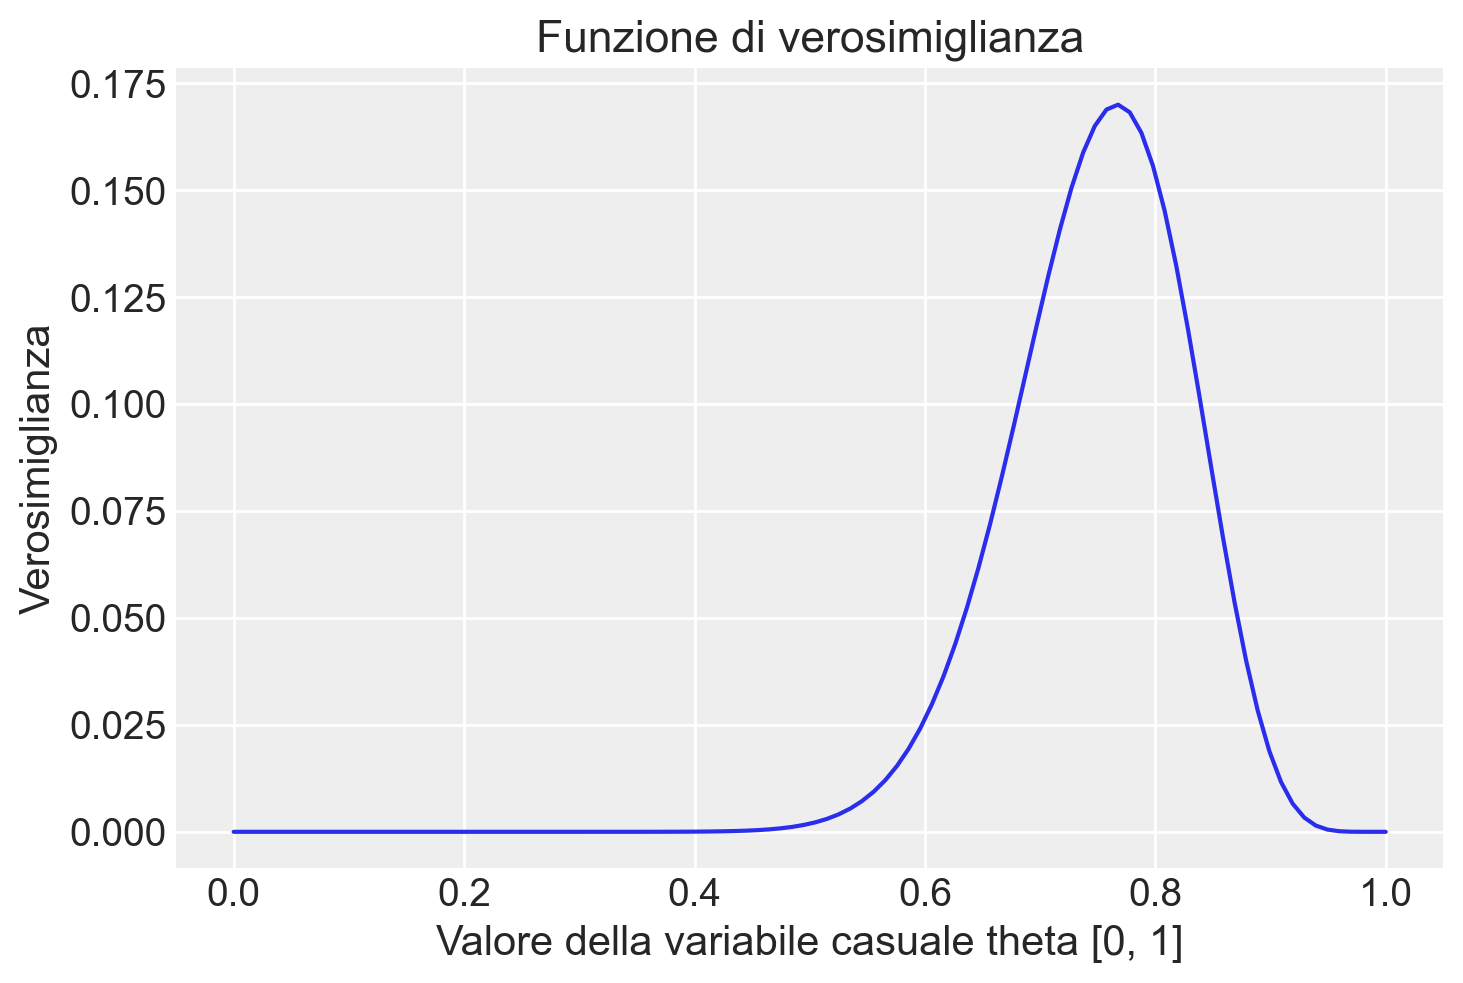

In [18]:
plt.figure()
plt.plot(theta, like(r=y, n=n, theta=theta), "-")
plt.title("Funzione di verosimiglianza")
plt.xlabel("Valore della variabile casuale theta [0, 1]")
plt.ylabel("Verosimiglianza");

È importante notare che, invece di utilizzare la funzione `like()` che abbiamo definito precedentemente per motivi didattici, è possibile ottenere lo stesso risultato utilizzando in modo equivalente la funzione `binom.pmf()`. 

Text(0, 0.5, 'Verosimiglianza')

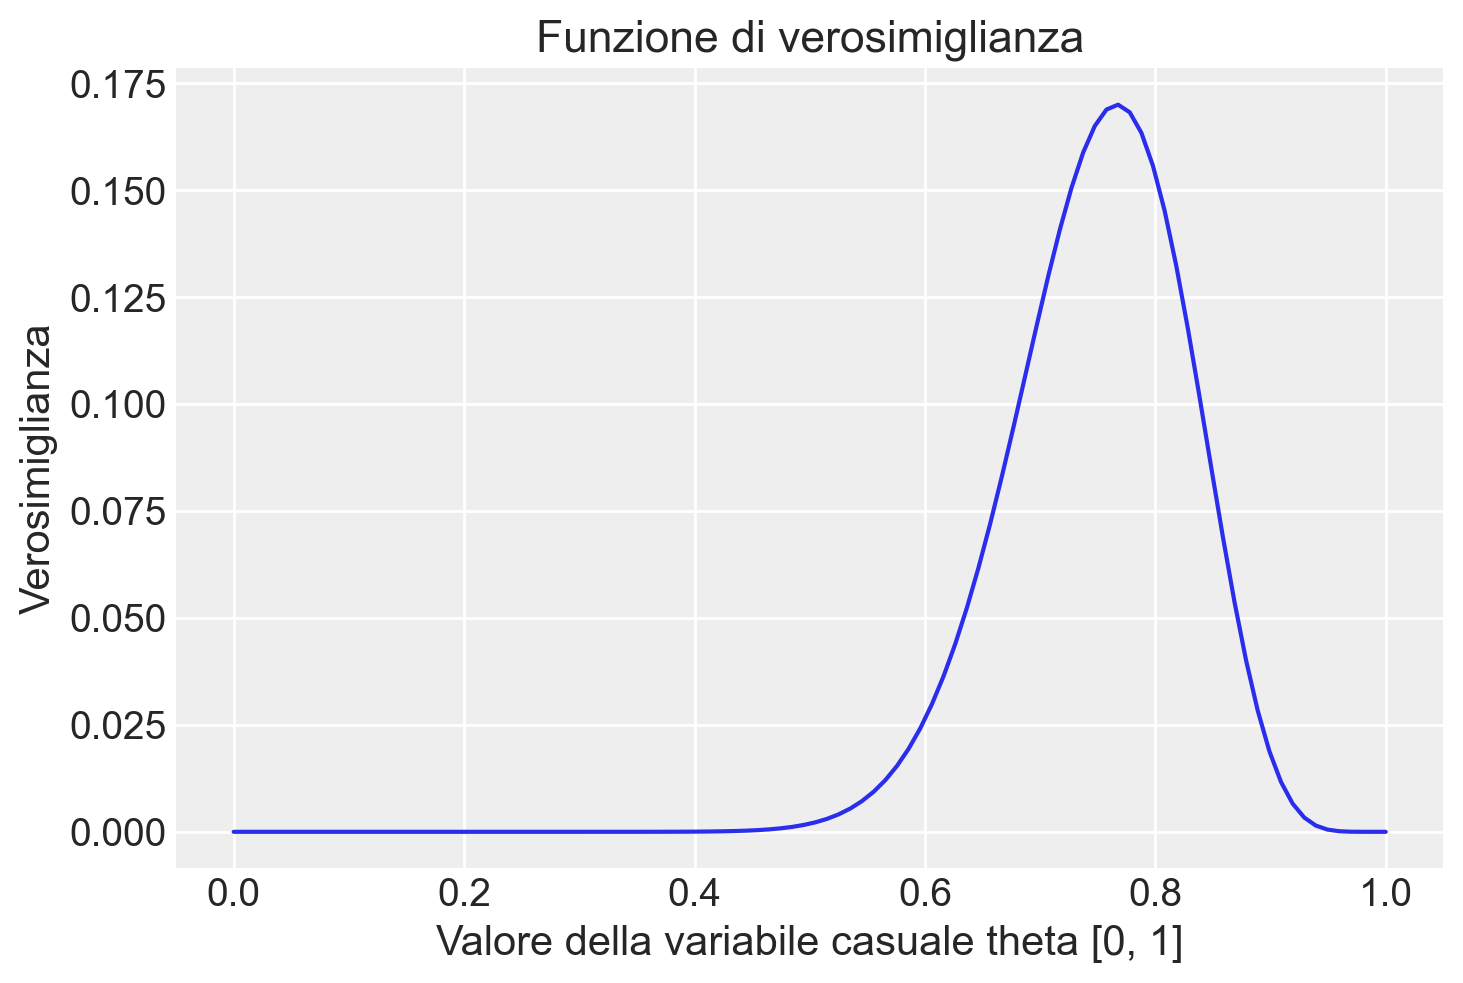

In [19]:
plt.figure()
plt.plot(theta, stats.binom.pmf(y, n, theta), "-")
plt.title("Funzione di verosimiglianza")
plt.xlabel("Valore della variabile casuale theta [0, 1]")
plt.ylabel("Verosimiglianza")

:::

### Interpretazione della Funzione di Verosimiglianza

La funzione di verosimiglianza ci permette di valutare quanto bene i diversi valori di $\theta$ si adattano ai dati osservati. Il valore che massimizza la funzione di verosimiglianza rappresenta la stima più plausibile di $\theta$ dato l'insieme di dati. Ad esempio, se il valore che massimizza la verosimiglianza è $\theta = 0.767$, ciò suggerisce che la probabilità più plausibile di successo (o, nel nostro caso, di atteggiamento negativo) nella popolazione studiata è del 76.7%.

La determinazione numerica di questo valore ottimale può essere effettuata mediante tecniche di ottimizzazione. Metodi computazionali, come quelli disponibili in linguaggi di programmazione come Python, permettono di identificare il punto in cui la funzione di verosimiglianza raggiunge il massimo. L'uso di librerie statistiche e matematiche, come NumPy o SciPy, consente di calcolare la stima di $\theta$ in modo preciso ed efficiente, fornendo un parametro che meglio si adatta ai dati osservati.

Questa metodologia, centrata sull'uso della funzione di verosimiglianza, è fondamentale nell'inferenza statistica. Essa consente ai ricercatori di stimare i parametri di un modello basandosi sui dati empirici, e di valutare l'adeguatezza del modello rispetto ai dati reali.

In pratica, per identificare numericamente il valore ottimale di $\theta$, si può utilizzare un approccio computazionale che identifica il massimo della verosimiglianza. Ad esempio, la funzione `argmax` di NumPy può essere impiegata per localizzare l'indice del vettore dei valori di verosimiglianza in cui si raggiunge il picco. Una volta identificato questo indice, si risale al corrispondente valore di $\theta$, ottenendo così la stima del parametro che rende i dati osservati più plausibili.

In [21]:
l = stats.binom.pmf(y, n, theta)
l.argmax()

76

In [22]:
theta[76]

0.7676767676767677

## Massima Verosimiglianza

Quando cerchiamo di stimare i parametri di un modello, come $\theta$, il nostro obiettivo è trovare il valore che massimizza la probabilità dei dati osservati, ovvero quello che corrisponde al massimo della funzione di verosimiglianza.

In termini di ottimizzazione, possiamo parlare di "minimizzazione" o "massimizzazione" a seconda della funzione. La minimizzazione consiste nel trovare il punto più basso di una "valle", mentre la massimizzazione implica trovare il punto più alto su una "collina". Nel caso della funzione di verosimiglianza, vogliamo trovare il punto in cui questa funzione raggiunge il suo valore massimo. Tuttavia, poiché molti algoritmi sono progettati per minimizzare le funzioni, possiamo convertire il problema cercando di minimizzare il negativo della funzione di verosimiglianza, il cui minimo corrisponderà al massimo della funzione originale.

### La Strategia di Base

L'ottimizzazione segue alcune fasi generali:

- **Punto di Partenza**: L'algoritmo inizia da un punto iniziale, scelto casualmente o basato su un'ipotesi ragionevole.
- **Esplorazione**: L'algoritmo "esplora" la superficie della funzione, spostandosi nelle direzioni che sembrano portare verso il minimo (o massimo, se stiamo massimizzando). È simile a sentirsi il terreno intorno a noi e camminare nella direzione della discesa.
- **Aggiustamento**: Durante l'esplorazione, l'algoritmo regola la traiettoria in base a ciò che rileva. Se trova una discesa, continua in quella direzione; se incontra una salita, prova a cambiare rotta.
- **Convergenza**: L'algoritmo procede fino a quando non trova un punto in cui non ci sono più discese significative, suggerendo di aver raggiunto il minimo (o massimo) raggiungibile con quel percorso.

### Metodi di Ottimizzazione

Esistono diversi metodi che l'algoritmo può utilizzare per determinare come muoversi:

- **Discesa del Gradiente (Gradient Descent)**: Utilizza il gradiente della funzione, che indica la direzione e la pendenza, per decidere in che direzione spostarsi.
- **Metodo di Newton-Raphson**: Impiega sia il gradiente che la curvatura della funzione (ossia la derivata seconda) per compiere passi più informati verso il minimo.
- **Algoritmi Genetici**: Ispirati alla selezione naturale, questi algoritmi generano soluzioni "evolutive" attraverso iterazioni che simulano l'evoluzione biologica.

### Interpretazione Intuitiva

L'ottimizzazione può essere vista come un processo di esplorazione metodica, in cui l'algoritmo riceve continuamente feedback dalla funzione che sta cercando di ottimizzare. Questo feedback guida il percorso verso il punto ottimale, che può essere il massimo o il minimo della funzione, a seconda del problema.

### Ottimizzazione della Verosimiglianza

Per trovare il massimo della funzione di verosimiglianza, possiamo quindi definire e minimizzare il negativo della funzione stessa. Questo ci permette di utilizzare algoritmi di minimizzazione per raggiungere il massimo, ottenendo così la stima del parametro $\theta$ che meglio si adatta ai dati osservati.

In [25]:
def negative_likelihood(theta, n, y):
    # Calcolo del negativo della funzione di verosimiglianza
    return -stats.binom.pmf(y, n, theta)

Utilizziamo ora `scipy.optimize.minimize` per trovare il valore di theta che massimizza la verosimiglianza. Bisogna specificare un valore iniziale per theta, qui assumiamo 0.5 come punto di partenza. I vincoli su theta sono che deve essere compreso tra 0 e 1.

In [26]:
result = minimize(negative_likelihood, x0=0.5, args=(n, y), bounds=[(0, 1)])
result.x

array([0.76666666])

## La Funzione di Log-Verosimiglianza

Proseguendo con l'analisi della funzione di verosimiglianza, ci avviciniamo a una sua trasformazione matematica frequentemente utilizzata dagli statistici: la funzione di log-verosimiglianza. Questa è definita come il logaritmo naturale della funzione di verosimiglianza:

$$
\ell(\theta) = \log \mathcal{L}(\theta \mid y),
$$

La log-verosimiglianza non altera la posizione del massimo della funzione di verosimiglianza, grazie alla proprietà di monotonicità del logaritmo. In termini pratici, il valore di $\theta$ che massimizza la log-verosimiglianza, denotato come $\hat{\theta}$, è lo stesso che massimizza la verosimiglianza originale:

$$
\hat{\theta} = \arg \max_{\theta \in \Theta} \ell(\theta) = \arg \max_{\theta \in \Theta} \mathcal{L}(\theta).
$$

L'uso della log-verosimiglianza semplifica il processo di ottimizzazione, specialmente quando si lavora con numeri molto piccoli o con dataset di grandi dimensioni. La log-verosimiglianza trasforma infatti il prodotto delle probabilità in una somma di logaritmi, facilitando i calcoli e migliorando la stabilità numerica. Questo è particolarmente utile nei casi in cui si gestiscono molte osservazioni, evitando problemi di underflow (quando i numeri diventano troppo piccoli per essere rappresentati accuratamente). 

Ad esempio, per un modello binomiale, la log-verosimiglianza è data da:

$$
\ell(\theta \mid y) = \log(\theta^y (1 - \theta)^{n - y}) = y \log(\theta) + (n - y) \log(1 - \theta).
$$

Questa trasformazione rende i calcoli più semplici perché converte il prodotto di probabilità in una somma, semplificando l'ottimizzazione, soprattutto in presenza di osservazioni indipendenti. Inoltre, la funzione logaritmica consente un'esecuzione più efficiente delle operazioni numeriche, rendendo l'analisi più stabile.

### Esempio: Applicazione della Log-Verosimiglianza

Riprendendo l'esempio della distribuzione binomiale, possiamo applicare la funzione di log-verosimiglianza per stimare il parametro $\theta$ che meglio si adatta ai dati osservati. Metodi computazionali, come l'uso di librerie statistiche in Python, ad esempio tramite `binom.logpmf()`, permettono di calcolare direttamente la log-verosimiglianza per un insieme di osservazioni e diversi valori di $\theta$. In questo modo, è possibile identificare il valore di $\theta$ che massimizza la log-verosimiglianza e ottenere una stima accurata e computazionalmente efficiente del parametro.

### Vantaggi della Log-Verosimiglianza

L'adozione della funzione di log-verosimiglianza non solo risolve problemi pratici legati alla manipolazione di probabilità molto piccole, ma offre anche una struttura concettuale più chiara per interpretare la plausibilità dei parametri del modello dati gli osservati. Questa trasformazione è fondamentale nell'analisi inferenziale, poiché migliora la precisione delle stime e la robustezza numerica durante il processo di ottimizzazione.

### Rappresentazione Grafica

Infine, una rappresentazione grafica della funzione di log-verosimiglianza fornisce ulteriori intuizioni sul comportamento della funzione stessa e aiuta a visualizzare chiaramente il punto in cui viene massimizzata, facilitando l'interpretazione delle stime dei parametri.

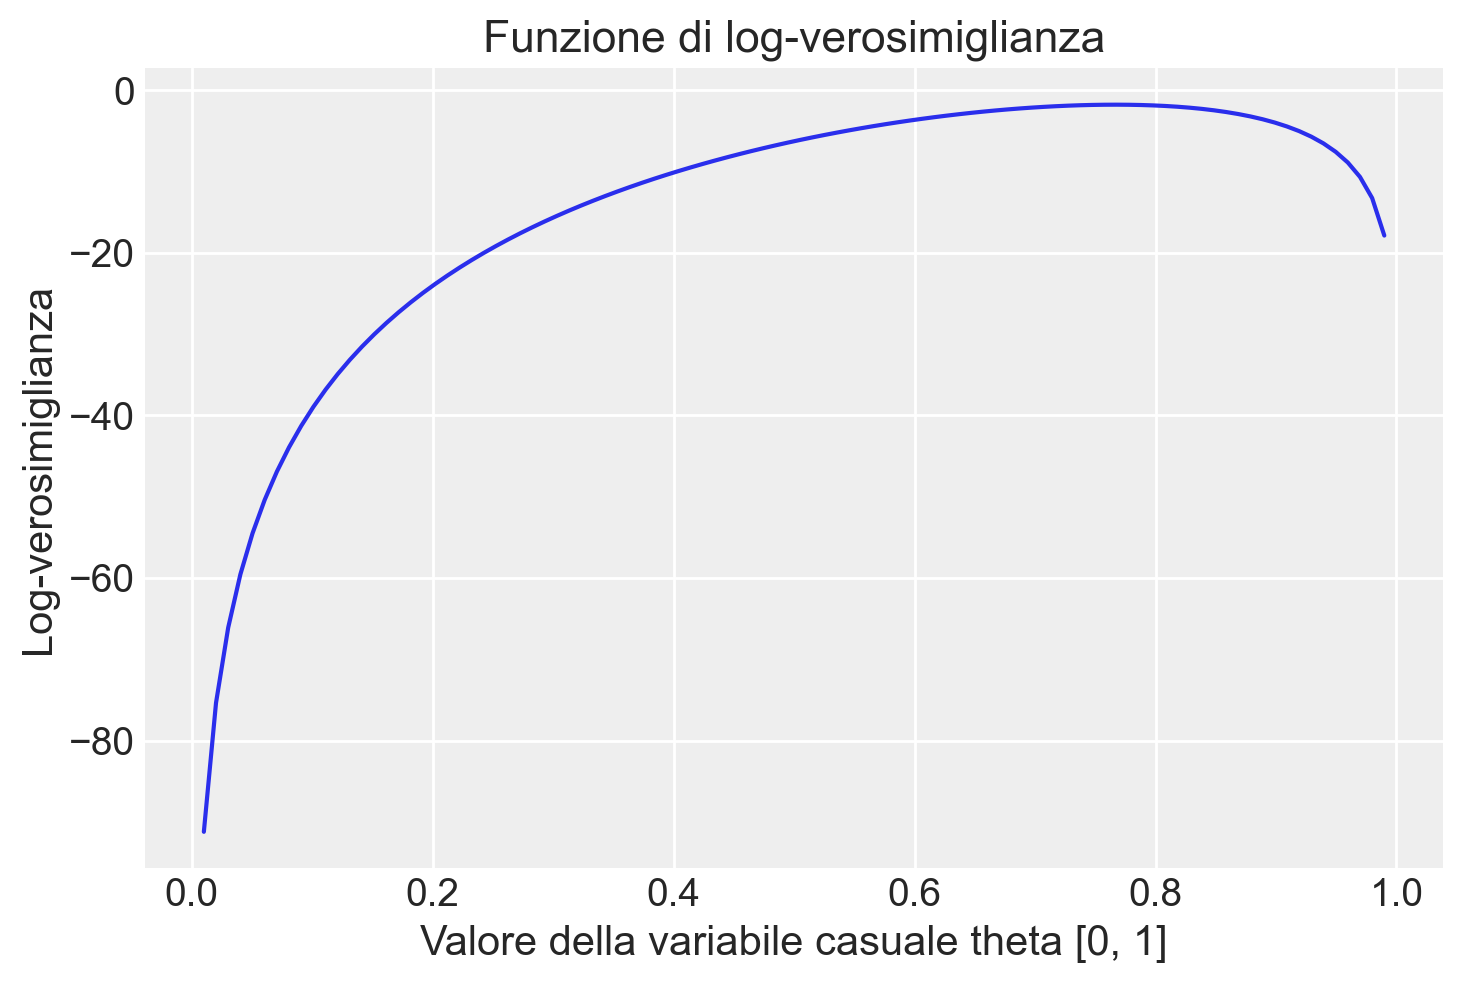

In [27]:
n = 30
r = 23
plt.figure()
plt.plot(theta, stats.binom.logpmf(y, n, theta), "-")
plt.title("Funzione di log-verosimiglianza")
plt.xlabel("Valore della variabile casuale theta [0, 1]")
plt.ylabel("Log-verosimiglianza");

Il risultato replica quello trovato in precedenza con la funzione di verosimiglianza.


In [28]:
ll = stats.binom.logpmf(y, n, theta)
ll.argmax()

76

In [29]:
theta[76]

0.7676767676767677

Definizione della funzione del negativo della log-verosimiglianza con correzioni per evitare errori di dominio:

In [30]:
def corrected_negative_log_likelihood(theta, n, y):
    # Assicurarsi che theta sia all'interno di un intervallo valido per evitare errori di logaritmo
    theta = np.clip(theta, 1e-10, 1-1e-10)
    return - (y * np.log(theta) + (n - y) * np.log(1 - theta))

Utilizzo di `scipy.optimize.minimize` per trovare il valore di theta che massimizza la log-verosimiglianza:

In [31]:
result_log_likelihood_corrected = minimize(
    corrected_negative_log_likelihood, x0=[0.5], args=(n, y), bounds=[(0, 1)]
)

In [32]:
# Il risultato ottimizzato per theta utilizzando la log-verosimiglianza corretta
optimized_theta = result_log_likelihood_corrected.x
optimized_theta

array([0.76666666])

## Verosimiglianza Congiunta

Proseguendo nell'esplorazione dell'inferenza statistica basata sulla verosimiglianza, ci soffermiamo ora sul caso in cui disponiamo di più osservazioni indipendenti, tutte provenienti dalla stessa distribuzione binomiale. Questo scenario è comune nelle applicazioni pratiche, dove raccogliamo un insieme di $n$ osservazioni $Y = [y_1, y_2, \ldots, y_n]$, ciascuna ottenuta nelle stesse condizioni sperimentali e indipendentemente dalle altre (condizione di indipendenza e identica distribuzione, IID).

Per analizzare queste osservazioni congiuntamente, dobbiamo calcolare la probabilità congiunta di osservare $y_1, y_2, \ldots, y_n$, data una comune probabilità di successo $\theta$ per tutte le prove. L'indipendenza delle osservazioni ci permette di esprimere questa probabilità congiunta come il prodotto delle probabilità individuali di ciascuna osservazione:

$$
p(y_1, y_2, \ldots, y_n \mid \theta) = \prod_{i=1}^{n} p(y_i \mid \theta) = \prod_{i=1}^{n} \text{Binomiale}(y_i \mid \theta).
$$

In questo contesto, la verosimiglianza congiunta rappresenta la plausibilità complessiva di $\theta$, dati tutti i dati osservati $Y$. È semplicemente il prodotto delle verosimiglianze individuali di ciascuna osservazione $y_i$ rispetto a $\theta$:

$$
\mathcal{L}(\theta \mid Y) = \prod_{i=1}^{n} \mathcal{L}(\theta \mid y_i) = \prod_{i=1}^{n} p(y_i \mid \theta).
$$

Questa formulazione della verosimiglianza congiunta evidenzia quanto bene il parametro $\theta$ si adatta all'intero insieme di dati $Y$, offrendo un quadro coerente per l'inferenza statistica. Il parametro $\theta$ che massimizza la verosimiglianza congiunta è chiamato **stimatore di massima verosimiglianza (MLE)**. Questo stimatore rappresenta il valore di $\theta$ che rende l'intero set di dati $Y$ il più plausibile possibile, secondo il modello scelto.

L'approccio basato sulla verosimiglianza congiunta è potente, poiché ci permette di considerare tutte le osservazioni contemporaneamente, sfruttando l'informazione fornita da ciascun dato per ottenere una stima più precisa e affidabile del parametro $\theta$.

Facciamo un esempio concreto. Quando disponiamo di più gruppi di osservazioni Bernoulliane indipendenti e identicamente distribuite (iid), la funzione di log-verosimiglianza congiunta per tutti i gruppi può essere espressa come la somma delle log-verosimiglianze di ciascun gruppo. Questo deriva dalla proprietà secondo cui il logaritmo di un prodotto è uguale alla somma dei logaritmi.

Supponiamo di avere i seguenti dati per quattro gruppi di osservazioni:

- **Gruppo 1**: 30 prove con 23 successi
- **Gruppo 2**: 28 prove con 21 successi
- **Gruppo 3**: 40 prove con 31 successi
- **Gruppo 4**: 36 prove con 29 successi

La funzione di log-verosimiglianza congiunta per questi dati, assumendo una singola probabilità di successo $\theta$ comune a tutti i gruppi, è data dalla seguente espressione:

$$
\log L(\theta) = \sum_{i=1}^{4} \left[ y_i \log(\theta) + (n_i - y_i) \log(1 - \theta) \right],
$$

dove $n_i$ e $y_i$ rappresentano rispettivamente il numero di prove e il numero di successi nel gruppo $i$-esimo.

Per trovare il valore di $\theta$ che massimizza questa funzione di log-verosimiglianza, possiamo utilizzare metodi di ottimizzazione numerica come `scipy.optimize.minimize` in Python. Questo metodo ci permette di minimizzare il negativo della funzione di log-verosimiglianza, il che equivale a massimizzarla. Inoltre, per evitare problemi numerici (ad esempio, logaritmi di zero), possiamo utilizzare `np.clip` per limitare i valori di $\theta$ all'interno di un intervallo ragionevole (ad esempio, tra $10^{-10}$ e $1 - 10^{-10}$).

In [7]:
def log_verosimiglianza_congiunta(theta, dati):
    theta = np.clip(theta, 1e-10, 1-1e-10)  # Evita valori esattamente 0 o 1
    log_likelihood = 0
    for n, y in dati:
        log_likelihood += y * np.log(theta) + (n - y) * np.log(1 - theta)
    return -log_likelihood  # Restituisce il negativo per l'ottimizzazione

In [8]:
# Dati dei gruppi: (prove, successi)
dati_gruppi = [(30, 23), (28, 20), (40, 29), (36, 29)]
print(dati_gruppi)

[(30, 23), (28, 20), (40, 29), (36, 29)]


Ottimizzazione con la funzione `log_verosimiglianza_congiunta`

In [9]:
result = minimize(
    log_verosimiglianza_congiunta, x0=[0.5], args=(dati_gruppi,), bounds=[(0, 1)]
)

# Il risultato ottimizzato per theta con la funzione corretta
result.x

array([0.75373134])

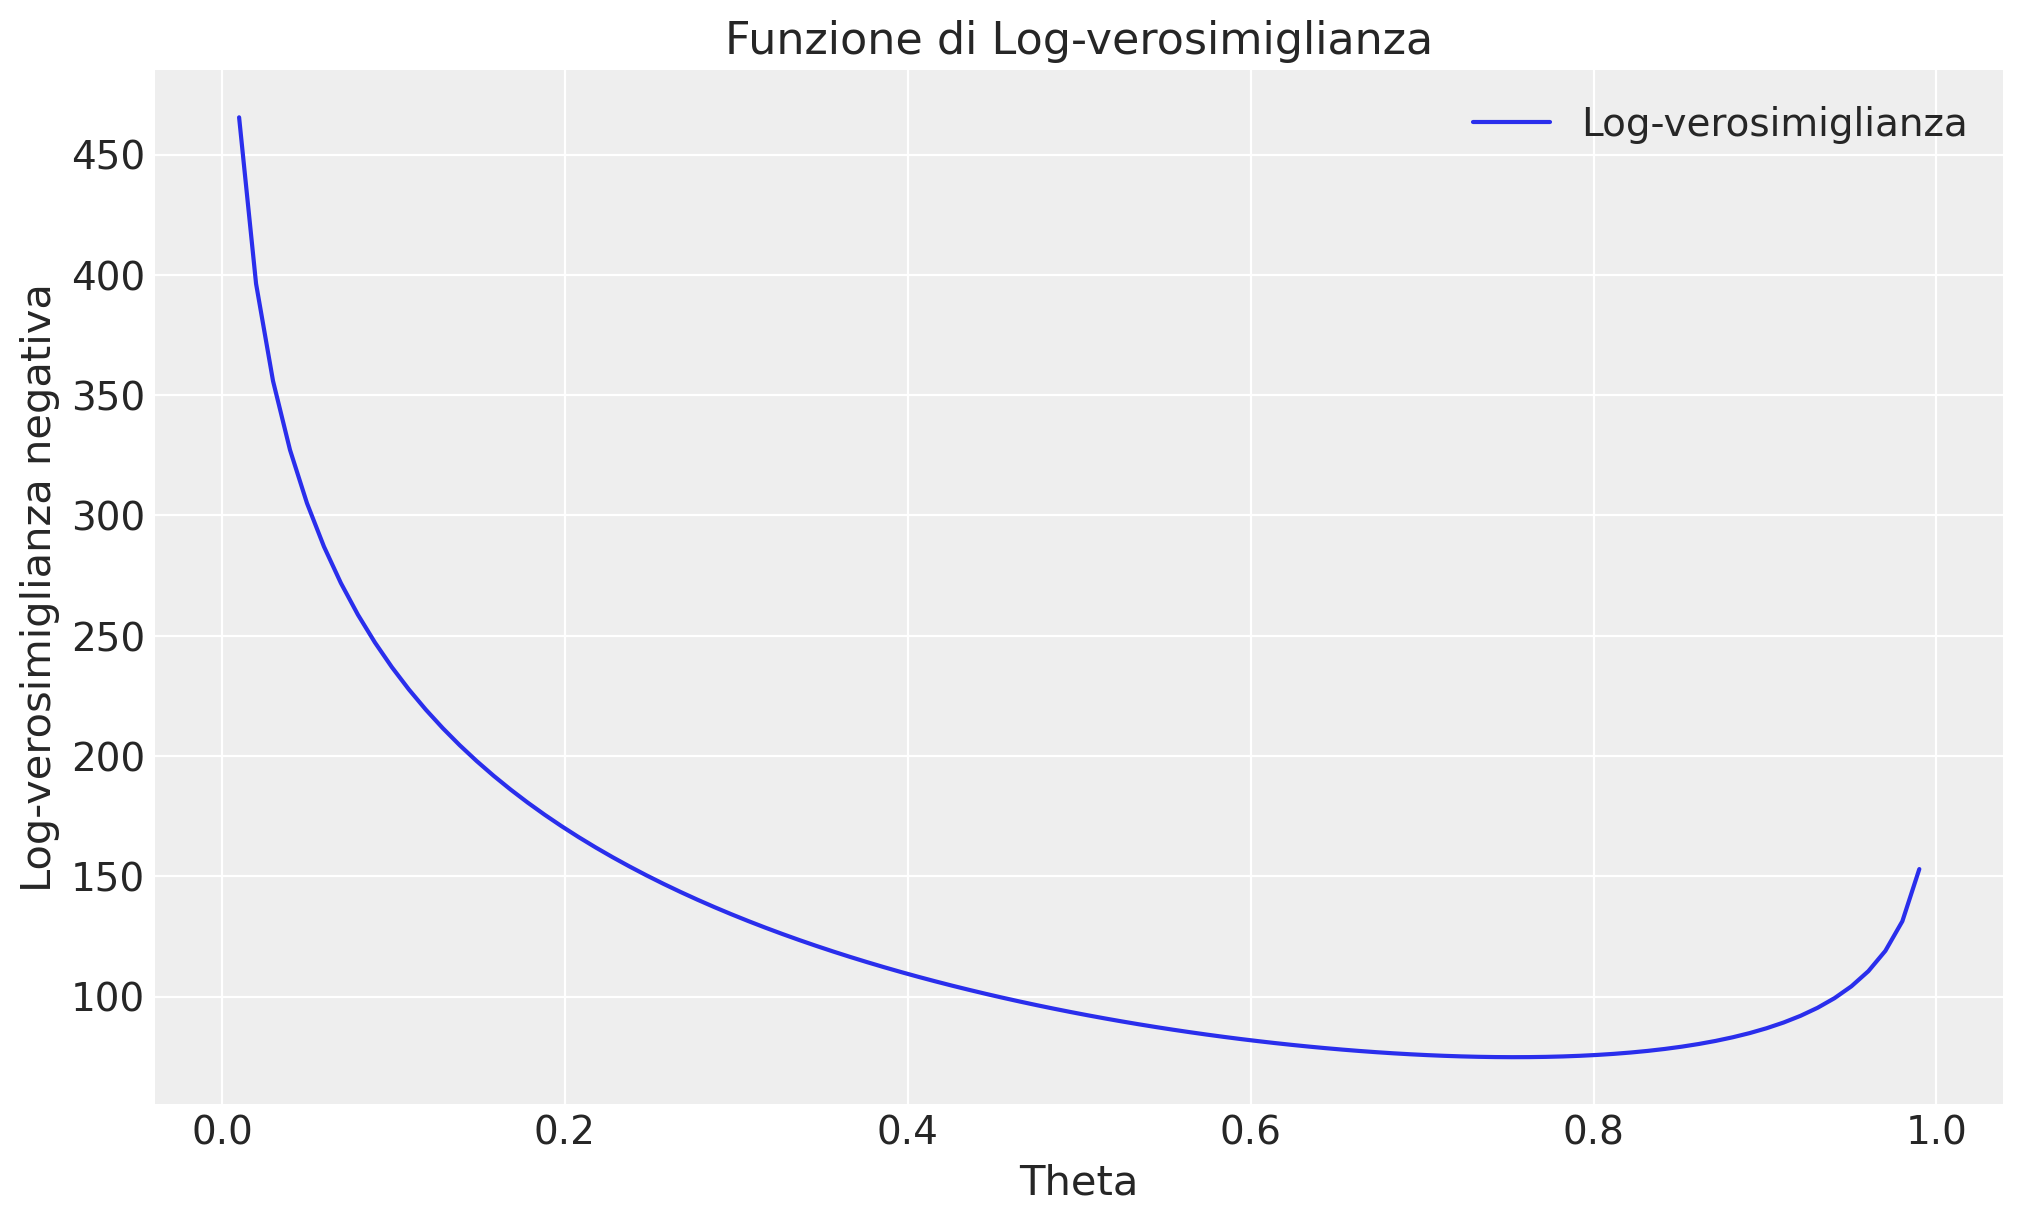

In [10]:
# Intervallo di valori di theta da esplorare
theta_values = np.linspace(0.01, 0.99, 100)

# Calcolo dei valori di log-verosimiglianza per ogni theta
log_likelihood_values = [log_verosimiglianza_congiunta(theta, dati_gruppi) for theta in theta_values]

# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.plot(theta_values, log_likelihood_values, label='Log-verosimiglianza')
plt.xlabel('Theta')
plt.ylabel('Log-verosimiglianza negativa')
plt.title('Funzione di Log-verosimiglianza')
plt.legend()
plt.grid(True)
plt.show()

In questo esempio, utilizziamo `minimize` per ottimizzare la funzione di log-verosimiglianza congiunta e ottenere una stima di $\theta$. Il valore risultante di $\theta$ rappresenta la stima di massima verosimiglianza (MLE) basata sui dati forniti.

In conclusione, questo esempio illustra come sia possibile stimare il parametro $\theta$ utilizzando la log-verosimiglianza congiunta in presenza di più gruppi di dati. La combinazione della funzione di log-verosimiglianza con tecniche di ottimizzazione numerica rende possibile risolvere problemi di inferenza anche con dataset più complessi o con più gruppi di osservazioni.

## La Verosimiglianza Marginale

Proseguendo con la nostra discussione sulla verosimiglianza, approfondiamo un concetto chiave nell'inferenza bayesiana: la verosimiglianza marginale. Questo concetto è cruciale quando il parametro di interesse, $\theta$, non è un valore fisso, ma è descritto da una distribuzione di probabilità che riflette la nostra incertezza o variabilità.

In molte applicazioni pratiche, $\theta$ può assumere una gamma di valori possibili, ciascuno con una certa probabilità associata, anziché essere un valore deterministico. La verosimiglianza marginale ci consente di calcolare la probabilità complessiva di osservare un determinato risultato tenendo conto di tutti i possibili valori di $\theta$, integrando o sommando le probabilità associate a ciascun valore di $\theta$.

### Esempio con Parametri Discreti

Consideriamo una sequenza di prove binomiali, in cui stiamo osservando un risultato specifico, come $k = 7$ successi su $n = 10$ prove. Se $\theta$ rappresenta la probabilità di successo in ciascuna prova e può assumere un insieme discreto di valori (ad esempio, 0.1, 0.5 e 0.9), ciascuno con probabilità uguale, la verosimiglianza marginale può essere calcolata come:

$$
p(k = 7, n = 10) = \sum_{\theta \in \{0.1, 0.5, 0.9\}} \binom{10}{7} \theta^7 (1 - \theta)^3 p(\theta),
$$

dove $p(\theta)$ è la probabilità associata a ciascun valore di $\theta$. In questo caso, poiché $\theta$ assume valori discreti, la somma calcola la verosimiglianza complessiva pesando i diversi valori di $\theta$ in base alla loro probabilità.

### Esempio con Parametri Continui

Nella maggior parte delle applicazioni reali, $\theta$ può variare continuamente all'interno di un intervallo, ad esempio tra 0 e 1 in una distribuzione binomiale. In questi casi, la verosimiglianza marginale richiede l'integrazione su tutto lo spazio dei valori di $\theta$, per tener conto della gamma continua di possibili probabilità di successo. La formula si estende a:

$$
p(k = 7, n = 10) = \int_{0}^{1} \binom{10}{7} \theta^7 (1 - \theta)^3 p(\theta) \, d\theta,
$$

dove $p(\theta) \, d\theta$ rappresenta la densità di probabilità di $\theta$ in un intervallo infinitesimale, e l'integrale copre tutti i possibili valori di $\theta$ nell'intervallo da 0 a 1.

### Calcolo della Verosimiglianza Marginale

Per calcolare la verosimiglianza marginale in presenza di una distribuzione continua di $\theta$, possiamo utilizzare tecniche di integrazione numerica. In Python, la libreria `scipy` offre strumenti efficienti per eseguire questo tipo di calcoli. Ad esempio, possiamo utilizzare la funzione `quad` di `scipy.integrate` per integrare la funzione su uno spazio continuo:

In [14]:
# Definire la funzione di verosimiglianza
def likelihood(theta):
    return stats.binom.pmf(k=7, n=10, p=theta)

# Calcolare la verosimiglianza marginale integrando su θ
marginal_likelihood, _ = quad(lambda theta: likelihood(theta), 0, 1)

print("La verosimiglianza marginale è:", marginal_likelihood)

La verosimiglianza marginale è: 0.09090909090909094


In conclusione, l'esempio presentato illustra come integrare la probabilità su un insieme continuo di valori di $\theta$ per ottenere la probabilità complessiva di osservare un determinato risultato. Il codice precedente esegue l'integrazione della funzione di verosimiglianza binomiale su tutti i possibili valori di $\theta$ (da 0 a 1), fornendo così la verosimiglianza marginale per il nostro esempio. Questo approccio consente di tenere conto dell'incertezza su $\theta$, offrendo una visione più completa della verosimiglianza dell'evento osservato senza fissare $\theta$ a un singolo valore.

Dal punto di vista numerico, nel caso della verosimiglianza basata su una distribuzione binomiale, la verosimiglianza marginale può essere interpretata come l'area sottesa dalla funzione di verosimiglianza, calcolata integrandola su tutto l'intervallo dei possibili valori di $\theta$ (da 0 a 1). Questa integrazione fornisce un valore che quantifica quanto bene il modello complessivo, considerando tutti i possibili valori di $\theta$, spiega i dati osservati. È importante notare che questo valore non rappresenta la probabilità dei dati dati i parametri, poiché la verosimiglianza non è una densità di probabilità sui parametri. Piuttosto, esso misura la capacità complessiva del modello di spiegare i dati, tenendo conto dell'incertezza sui parametri.

La vera rilevanza della verosimiglianza marginale emerge nel contesto dell'inferenza bayesiana: essa funge da fattore di normalizzazione nella formula di Bayes. Più precisamente, la verosimiglianza marginale normalizza il prodotto tra la verosimiglianza e la distribuzione a priori dei parametri (il numeratore nella formula di Bayes), garantendo che il risultato sia una distribuzione di probabilità valida sui parametri. In altre parole, la verosimiglianza marginale assicura che l'area sotto la curva della distribuzione posteriore sia pari a 1, rendendola una vera distribuzione di probabilità.

## Modello Gaussiano e Verosimiglianza

Ampliamo ora la nostra analisi al caso della distribuzione gaussiana. Inizieremo con la verosimiglianza associata a una singola osservazione $ Y $, per poi estendere la discussione a un insieme di osservazioni gaussiane indipendenti e identicamente distribuite (IID).

### Caso di una Singola Osservazione

Iniziamo esaminiamo il caso di una singola osservazione. Quale esempio, prendiamo in considerazione la situazione in cui una variabile casuale rappresenta il Quoziente d'Intelligenza (QI) di un individuo. Se consideriamo la distribuzione del QI come gaussiana, possiamo esprimere la funzione di verosimiglianza per un singolo valore osservato di QI tramite la formula della distribuzione gaussiana, che misura la probabilità di osservare quel particolare valore di QI dato un insieme di parametri specifici, $\mu$ (la media) e $\sigma$ (la deviazione standard). La verosimiglianza offre quindi un modo per quantificare quanto bene i parametri $\mu$ e $\sigma$ si accordano con il valore osservato di QI. 

Supponiamo che il QI osservato sia 114 e, per semplicità, assumiamo che la deviazione standard $\sigma$ sia conosciuta e pari a 15. Vogliamo esaminare un'ampia gamma di possibili valori per la media $\mu$, diciamo tra 70 e 160, e valutare quale di questi valori rende più plausibile l'osservazione fatta Definiamo quindi un insieme di 1000 valori per $\mu$ da esplorare:

In [15]:
mu = np.linspace(70.0, 160.0, num=1000)
y = 114

La nostra analisi consiste nell'applicare la funzione di densità di probabilità gaussiana a ciascuno di questi 1000 valori di $\mu$, mantenendo fisso il valore osservato di QI, $y=114$, e la deviazione standard, $\sigma=15$. In questo modo, possiamo costruire la funzione di verosimiglianza che esprime la plausibilità di ciascun valore di $\mu$ alla luce del QI osservato.

Il calcolo specifico della densità di probabilità per ogni valore di $\mu$ può essere eseguito con la funzione `norm.pdf` di `scipy.stats`, che accetta il valore osservato $y$, un array di medie (i nostri valori di $\mu$) e la deviazione standard $\sigma$. Per un singolo valore `mu` = 70, otteniamo

In [16]:
stats.norm.pdf(y, loc=70, scale=15)

0.00036007041207962535

Per il valore `mu` = 70.05 otteniamo

In [17]:
stats.norm.pdf(y, loc=70.05, scale=15)

0.00036360634900376967

e così via. Se usiamo utti i 1000 valori possibili di `mu`, otteniamo un vettore di 1000 risultati:

In [18]:
f_mu = stats.norm.pdf(y, loc=mu, scale=15)

Questo passaggio ci fornisce un array di valori che rappresentano la verosimiglianza di ciascun valore di $\mu$ data l'osservazione $y$. Tracciando questi valori `f_mu` in funzione di $\mu$, otteniamo una curva di verosimiglianza che illustra visivamente quanto bene ciascun valore di $\mu$ si adatta al dato osservato `y` = 114:

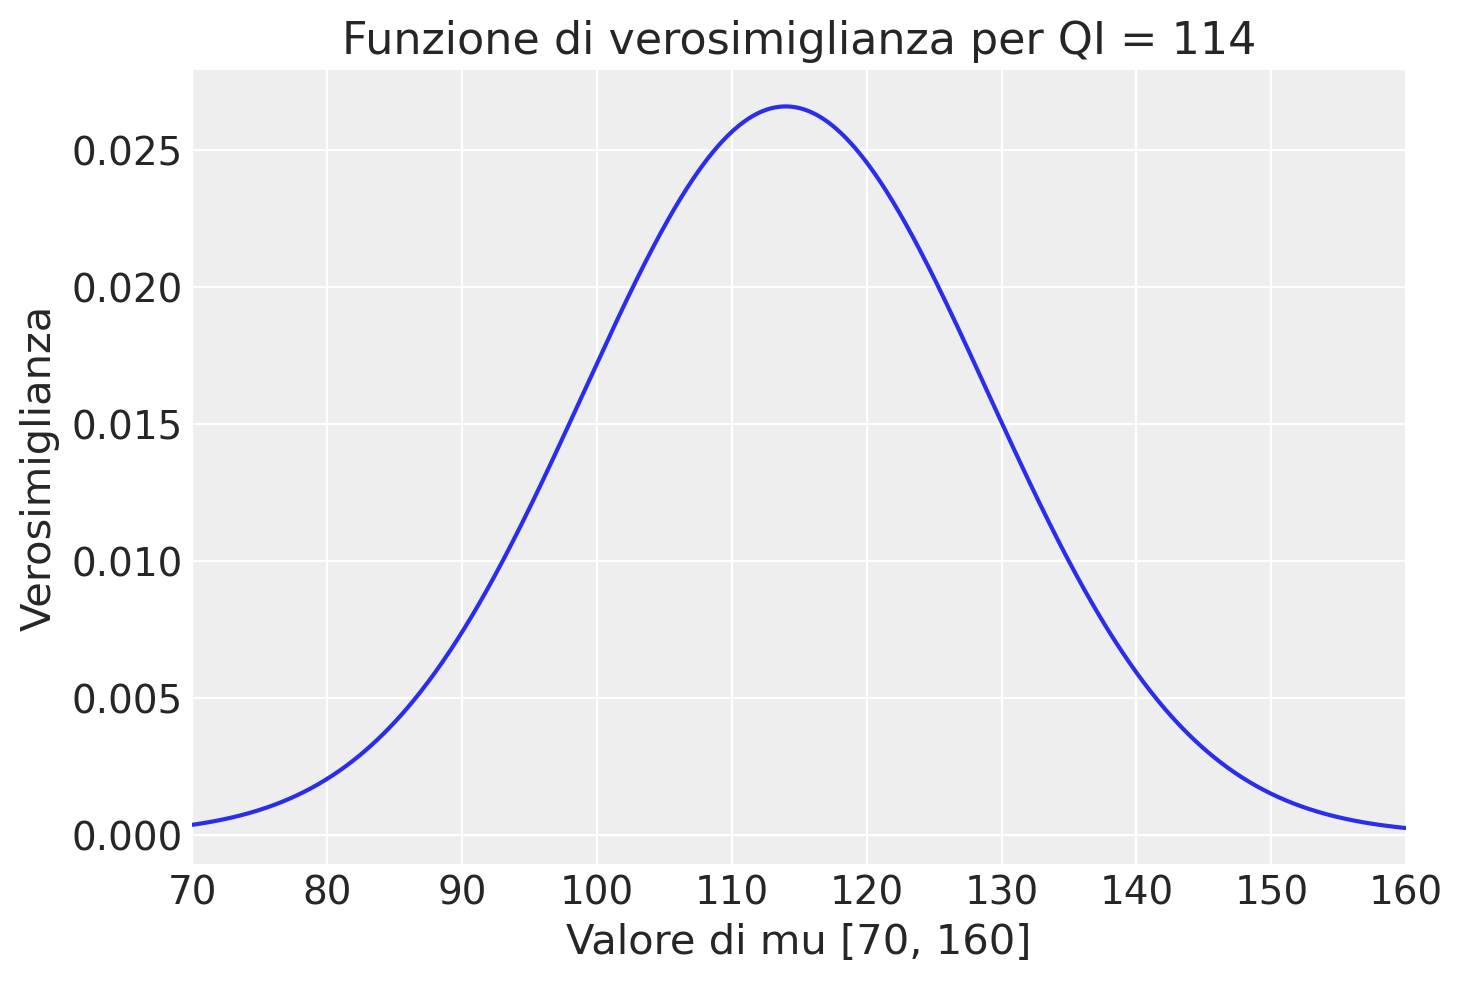

In [19]:
plt.figure()
plt.plot(mu, f_mu, "-")
plt.title("Funzione di verosimiglianza per QI = 114")
plt.xlabel("Valore di mu [70, 160]")
plt.ylabel("Verosimiglianza")
plt.xlim([70, 160])
plt.show()

Abbiamo dunque proceduto come nel caso della distribuzione binomiale esaminata in precedenza. Abbiamo utilizzato la formula 

$$
f(x | \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right),
$$

tenendo costante il valore $x$ = 114 e considerando noto $\sigma$ = 15, e abbiamo applicato la formula 1000 volte facendo variare `mu` ogni volta utilizziando ciascuno dei valori definiti con `np.linspace(70.0, 160.0, num=1000)`.

La moda della distribuzione, si trova con

In [20]:
optimal_mu = mu[f_mu.argmax()]
print(optimal_mu)

113.96396396396396


In questo esempio, otteniamo il valore $\mu$ = 113.96 che massimizza la verosimiglianza.

Per calcolare il massimo della log-verosimiglianza per una distribuzione Gaussiana usando la funzione `optimize()` di SciPy, possiamo seguire questi passi. Partiamo dalla formula della densità di probabilità della distribuzione gaussiana per una singola osservazione $y$, con media $\mu$ e deviazione standard $\sigma$. La formula è:

$$
f(y \mid \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left( -\frac{(y - \mu)^2}{2\sigma^2} \right)
$$

Poiché abbiamo una singola osservazione $y$, la funzione di verosimiglianza coincide con la funzione di densità di probabilità. Quindi, prendiamo il logaritmo naturale di entrambi i lati della equazione della densità di probabilità gaussiana per ottenere la log-verosimiglianza:

$$
\log f(y \mid \mu, \sigma) = \log \left( \frac{1}{\sigma \sqrt{2\pi}} \exp \left( -\frac{(y - \mu)^2}{2\sigma^2} \right) \right)
$$

Applichiamo le proprietà dei logaritmi. Ricordiamo che:

- $\log(ab) = \log(a) + \log(b)$
- $\log\left(\frac{1}{a}\right) = -\log(a)$
- $\log(e^x) = x$

Quindi, possiamo scrivere:

$$
\log f(y \mid \mu, \sigma) = \log\left(\frac{1}{\sigma \sqrt{2\pi}}\right) + \log\left(\exp \left( -\frac{(y - \mu)^2}{2\sigma^2} \right)\right)
$$

$$
= -\log(\sigma \sqrt{2\pi}) -\frac{(y - \mu)^2}{2\sigma^2}.
$$

Ricordando che $\log(ab) = \log(a) + \log(b)$, possiamo scrivere $\log(\sigma \sqrt{2\pi})$ come la somma di due logaritmi:

$$
-\log(\sigma \sqrt{2\pi}) = -\log(\sigma) - \log(\sqrt{2\pi}).
$$

E dato che $\log(\sqrt{2\pi}) = \frac{1}{2}\log(2\pi)$, possiamo sostituire per ottenere:

$$
-\log(\sigma) - \frac{1}{2}\log(2\pi).
$$

Combinando tutto, otteniamo:

$$
\log L(\mu; y, \sigma) = -\frac{1}{2} \log(2 \pi) - \log(\sigma) - \frac{(y - \mu)^2}{2 \sigma^2}.
$$

Questa è la trasformata logaritmica della funzione di densità di probabilità gaussiana per una singola osservazione, che rappresenta la log-verosimiglianza di osservare $y$ dato $\mu$ e $\sigma$. 

Vogliamo trovare il valore di $\mu$ che massimizza questa funzione di log-verosimiglianza. Siccome `optimize()` di SciPy minimizza una funzione, possiamo passare il negativo della log-verosimiglianza per trovare il massimo.

In [21]:
# Dati osservati
y_obs = 114
sigma = 15

# Definizione della funzione negativa della log-verosimiglianza
def negative_log_likelihood(mu, y, sigma):
    return 0.5 * np.log(2 * np.pi) + np.log(sigma) + ((y - mu)**2) / (2 * sigma**2)

# Ottimizzazione per trovare il valore di mu che massimizza la log-verosimiglianza
result = minimize(negative_log_likelihood, x0=0, args=(y_obs, sigma))

# Il risultato ottimizzato per mu
result.x

array([113.99997648])

Il valore di $\mu$ che massimizza la log-verosimiglianza per una distribuzione Gaussiana con $y = 114$ e $\sigma = 15$ è circa $114$. Questo risultato dimostra che, nel caso di una distribuzione Gaussiana con una singola osservazione e deviazione standard nota, il massimo della log-verosimiglianza si ottiene quando la media stimata $\mu$ è molto vicina al valore osservato $y$.

### Campione indipendente di osservazioni da una distribuzione gaussiana

Passiamo ora all'esame di un contesto più complesso: quello di un campione composto da $n$ osservazioni indipendenti, tutte provenienti da una distribuzione gaussiana. Consideriamo questo insieme di osservazioni come realizzazioni indipendenti ed identicamente distribuite (i.i.d.) di una variabile casuale $X$, che segue una distribuzione normale con media $ \mu $ e deviazione standard $\sigma$, entrambi parametri sconosciuti. Denotiamo questa situazione con la notazione $X \sim N(\mu, \sigma^2)$.

In presenza di osservazioni i.i.d., la densità di probabilità congiunta del campione è il prodotto delle funzioni di densità per ogni singola osservazione. Matematicamente, ciò si esprime attraverso l'equazione:

$$ p(y_1, y_2, \ldots, y_n | \mu, \sigma) = \prod_{i=1}^{n} p(y_i | \mu, \sigma), $$

dove $p(y_i | \mu, \sigma)$ indica la funzione di densità gaussiana per l'osservazione $y_i$, parametrizzata da $\mu$ e $\sigma$.

Se manteniamo i dati osservati come costanti, ciò che cambia in questa equazione quando variamo $ \mu $ e $\sigma$ sono le probabilità associate ad ogni configurazione dei parametri, portandoci così alla funzione di verosimiglianza congiunta per il campione.

::: {#exm-}
Consideriamo, per illustrare questa dinamica, il caso di uno studio clinico che misura i punteggi del Beck Depression Inventory II (BDI-II) su trenta partecipanti. Supponiamo che questi punteggi seguano una distribuzione normale. Dati i punteggi BDI-II per i trenta partecipanti, il nostro obiettivo è costruire una funzione di verosimiglianza per questi dati, assumendo che la deviazione standard $\sigma$ sia nota e pari alla deviazione standard campionaria di 6.50.

Per la totalità del campione, la densità di probabilità congiunta diventa quindi il prodotto delle densità per ogni osservazione. Di conseguenza, la funzione di verosimiglianza per il campione intero è rappresentata dal prodotto delle densità di probabilità di tutte le osservazioni.

In questo contesto, ogni possibile valore di $\mu$ viene valutato in termini di verosimiglianza. Per esemplificare, consideriamo un range di 1000 valori per $\mu$ e calcoliamo la funzione di verosimiglianza per ognuno di questi. Per rendere più gestibili i calcoli, utilizziamo il logaritmo della funzione di verosimiglianza.

Definendo una funzione `log_likelihood` in Python che accetta i punteggi BDI-II $y$, un valore medio $\mu$, e imposta $\sigma$ al valore noto, possiamo calcolare la log-verosimiglianza per un'ampia gamma di valori di $\mu$ entro un intervallo specifico. Ciò ci permette di visualizzare la credibilità relativa di ciascun valore di $\mu$ alla luce dei dati osservati.

Infine, il valore di $\mu$ che massimizza la funzione di log-verosimiglianza corrisponde alla stima di massima verosimiglianza di $\mu$ data la distribuzione dei punteggi BDI-II nel campione. Questo valore, nel nostro esempio, coincide con la media campionaria dei punteggi BDI-II, offrendo una stima concorde con l'intuizione che la media del campione sia un buon rappresentante del parametro $\mu$ in una distribuzione normale.

I dati sono:

In [22]:
y = [
    26, 35, 30, 25, 44, 30, 33, 43, 22, 43, 24, 19, 39, 31, 25,
    28, 35, 30, 26, 31, 41, 36, 26, 35, 33, 28, 27, 34, 27, 22,
]

Il nostro scopo è sviluppare una funzione di verosimiglianza utilizzando le 30 osservazioni indicate sopra. Basandoci su studi precedenti, ipotizziamo che questi punteggi seguano una distribuzione normale. Assumiamo inoltre che la deviazione standard $\sigma$ sia nota e corrisponda a quella osservata nel campione, ossia 6.50.

Per la prima osservazione del campione, dove $y_1 = 26$, la funzione di densità di probabilità si esprime come:

$$
f(26 \,|\, \mu, \sigma = 6.50) = \frac{1}{6.50\sqrt{2\pi}} \exp \left( -\frac{(26 - \mu)^2}{2 \cdot 6.50^2} \right).
$$

Estendendo questo calcolo all'intero campione, la funzione di densità di probabilità congiunta si ottiene come il prodotto delle densità di tutte le osservazioni individuali:

$$
f(y \,|\, \mu, \sigma = 6.50) = \prod_{i=1}^{n} f(y_i \,|\, \mu, \sigma = 6.50).
$$

Di conseguenza, la funzione di verosimiglianza, indicata con $\mathcal{L}(\mu, \sigma = 6.50 \,|\, y)$, si determina moltiplicando insieme le densità di probabilità di tutte le osservazioni nel campione:

$$
\begin{aligned}
\mathcal{L}(\mu, \sigma=6.50 \,|\, y) &= \prod_{i=1}^{30} \frac{1}{6.50\sqrt{2\pi}} \exp \left( -\frac{(y_i - \mu)^2}{2 \cdot 6.50^2} \right) \\
&= \left( \frac{1}{6.50\sqrt{2\pi}} \right)^{30} \exp\left( -\sum_{i=1}^{30} \frac{(y_i - \mu)^2}{2 \cdot 6.50^2} \right).
\end{aligned}
$$

In questa formula, $\mu$ rappresenta il parametro di interesse, la media della distribuzione, la cui stima massimizza la funzione di verosimiglianza. Se si considerano 1000 valori differenti per $\mu$, dovremmo calcolare la funzione di verosimiglianza per ciascuno di questi valori.

Per rendere i calcoli più gestibili, è consigliabile utilizzare il logaritmo della funzione di verosimiglianza. In Python, possiamo definire una funzione `log_likelihood()` che accetta come argomenti `y`, `mu` e `sigma = true_sigma`. Per semplificare, impostiamo `true_sigma` uguale alla deviazione standard osservata nel campione.

In [23]:
true_sigma = np.std(y)
print(true_sigma)

6.495810615739622


In [24]:
def log_likelihood(y, mu, sigma=true_sigma):
    return np.sum(stats.norm.logpdf(y, loc=mu, scale=true_sigma))

Consideriamo, ad esempio, il valore $\mu_0 = \bar{y}$, ovvero


In [25]:
bar_y = np.mean(y)
print(bar_y)

30.933333333333334


L'ordinata della funzione di log-verosimiglianza in corrispondenza di $\mu = 30.93$ è


In [26]:
log_likelihood(y, 30.93, sigma=true_sigma)

-98.70288339960591

Troviamo ora i valori della log-verosimiglianza per ciascuno dei 1000 valori $\mu$ nell'intervallo $[\bar{y} - 2 \sigma, \bar{y} + 2 \sigma]$. Iniziamo a definire il vettore `mu`.


In [27]:
mu = np.linspace(np.mean(y) - 2 * np.std(y), np.mean(y) + 2 * np.std(y), num=1000)

Troviamo il valore dell'ordinata della funzione di log-verosimiglianza in corrispondenza di ciascuno dei 1000 valori `mu` che abbiamo definito.

In [28]:
ll = [log_likelihood(y, mu_val, true_sigma) for mu_val in mu]

Nel caso di un solo parametro sconosciuto (nel caso presente, $\mu$) è possibile rappresentare la log-verosimiglianza con una curva che interpola i punti (`mu`, `ll`). Tale funzione descrive la *credibilità relativa* che può essere attribuita ai valori del parametro $\mu$ alla luce dei dati osservati.

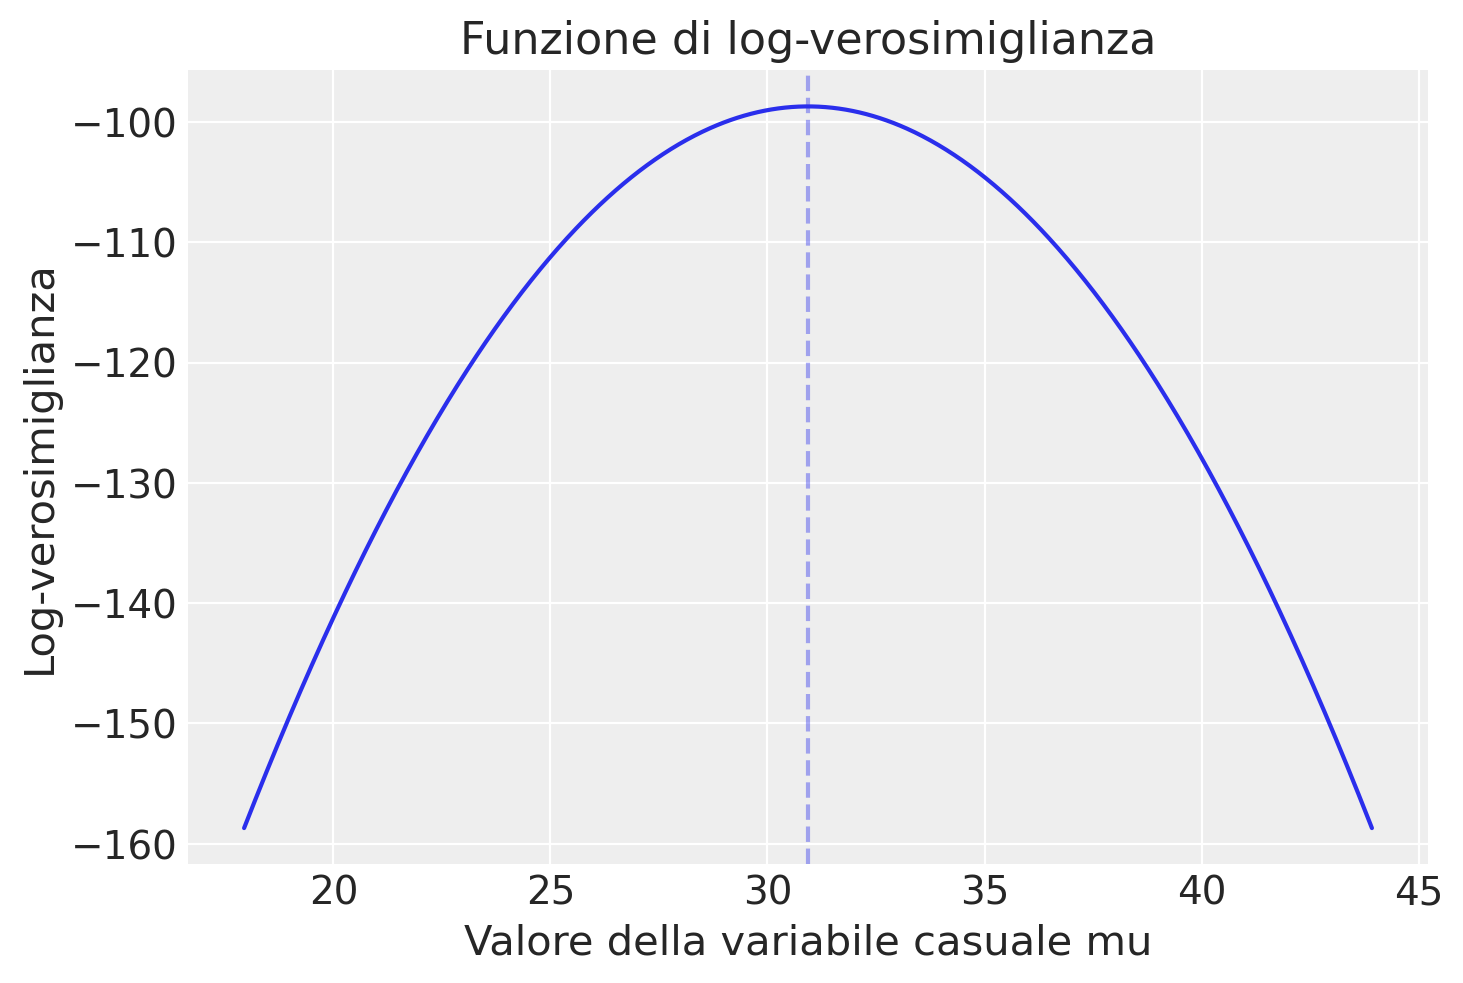

In [29]:
plt.figure()
plt.plot(mu, ll, "-")
plt.title("Funzione di log-verosimiglianza")
plt.xlabel("Valore della variabile casuale mu")
plt.ylabel("Log-verosimiglianza")
plt.axvline(x=np.mean(y), alpha=0.4, ls="--");

Il valore $\mu$ più credibile corrisponde al massimo della funzione di log-verosimiglinza e viene detto *stima di massima verosimiglianza*.

Il massimo della funzione di log-verosimiglianza, ovvero 30.93 per l'esempio in discussione, è identico alla media dei dati campionari. 

Per applicare lo stesso approccio usato precedentemente con `optimize` ad un campione di dati, anziché a una singola osservazione, possiamo modificare la funzione di log-verosimiglianza per prendere in considerazione tutte le osservazioni nel campione. La log-verosimiglianza per un campione da una distribuzione Gaussiana, dove ogni osservazione $y_i$ ha la stessa media $\mu$ e deviazione standard $\sigma$, è la somma delle log-verosimiglianze di ogni osservazione individuale.

La formula modificata per il campione sarà:

$$
\log L(\mu; y, \sigma) = \sum_{i=1}^{n} \left[ -\frac{1}{2} \log(2 \pi) - \log(\sigma) - \frac{(y_i - \mu)^2}{2 \sigma^2} \right],
$$

dove $y$ è l'array delle osservazioni e $n$ è il numero di osservazioni nel campione.

Poiché, per semplicità, assumiamo $\sigma$ come la deviazione standard del campione, prima calcoleremo $\sigma$ dal campione fornito e poi useremo quel valore per l'ottimizzazione della log-verosimiglianza, cercando il valore di $\mu$ che la massimizza.

In [30]:
# Calcolo della deviazione standard del campione
sigma_sample = np.std(y, ddof=1)

# Definizione della funzione negativa della log-verosimiglianza per il campione
def negative_log_likelihood_sample(mu, y, sigma):
    n = len(y)
    return n * 0.5 * np.log(2 * np.pi) + n * np.log(sigma) + np.sum((y - mu)**2) / (2 * sigma**2)

# Ottimizzazione per trovare il valore di mu che massimizza la log-verosimiglianza per il campione
result_sample = minimize(negative_log_likelihood_sample, x0=np.mean(y), args=(y, sigma_sample))

# Il risultato ottimizzato per mu
result_sample.x

array([30.93333333])

Il valore di $\mu$ che massimizza la log-verosimiglianza per il campione di dati fornito, assumendo noto il valore di $\sigma$ (la deviazione standard del campione), è circa $30.93$. Questo rappresenta la stima ottimale per la media della distribuzione Gaussiana che meglio si adatta al campione di dati dato.

:::

### La Stima di Massima Verosimiglianza per $\mu$

Per determinare il valore di $\mu$ che massimizza la funzione di log-verosimiglianza, procediamo calcolando la sua derivata parziale rispetto a $\mu$ e impostando il risultato uguale a zero:

1. Partiamo dalla funzione di log-verosimiglianza, che è data da:

   $$
   \ell = -\frac{n}{2} \log(2\pi) - \frac{n}{2} \log(\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (y_i - \mu)^2.
   $$

2. Calcoliamo la derivata parziale di $ \ell $ rispetto a $ \mu $:

   $$
   \frac{\partial \ell}{\partial \mu} = \sum_{i=1}^n \frac{(y_i - \mu)}{\sigma^2}.
   $$

3. Impostiamo la derivata uguale a zero per trovare il punto di massimo:

   $$
   \frac{1}{\sigma^2} \sum_{i=1}^n (y_i - \mu) = 0.
   $$

Risolvendo questa equazione per $ \mu $, otteniamo la stima di massima verosimiglianza:

$$
\hat{\mu}_{MLE} = \frac{1}{n} \sum_{i=1}^n y_i = \bar{y}.
$$

Questa formula ci mostra che la stima di massima verosimiglianza per $\mu$ corrisponde semplicemente alla media aritmetica delle osservazioni.

Questo processo può essere analogamente applicato per stimare $\sigma^2$, la varianza, e si trova che la stima di massima verosimiglianza per $\sigma^2$ è pari alla varianza campionaria.

In conclusione, all'interno di una distribuzione gaussiana, le stime di massima verosimiglianza per $\mu$ (la media) e $\sigma^2$ (la varianza) coincidono con la media campionaria e la varianza campionaria, rispettivamente. 

::: {#exm-}

Consideriamo un esempio relativo all'apprendimento per rinforzo. Lo scopo degli studi sull'apprendimento per rinforzo è quello di comprendere come le persone imparano a massimizzare le loro ricompense in situazioni in cui la scelta migliore è inizialmente sconosciuta. In modo più specifico, consideriamo il seguente problema di apprendimento. Un partecipante deve effettuare ripetutamente delle scelte tra diverse opzioni o azioni, e dopo ogni scelta riceve una ricompensa numerica estratta da una distribuzione di probabilità che dipende dall'azione selezionata. L'obiettivo del partecipante è massimizzare la ricompensa totale attesa durante un certo periodo di tempo, ad esempio, durante 100 scelte. Per descrivere questa situazione, viene spesso utilizzata la metafora di un giocatore che deve fare una serie di $T$ scelte tra $K$ slot machine (conosciute anche come "multi-armed bandits") al fine di massimizzare le sue vincite. Se nella scelta $t$ viene selezionata la slot machine $k$, viene ottenuta una ricompensa $r_t$ che ha valore `1` con una probabilità di successo $\mu^k_t$, altrimenti ha valore `0`. Le probabilità di successo sono diverse per ogni slot machine e inizialmente sono sconosciute al partecipante. Nella versione più semplice di questo compito, le probabilità di successo rimangono costanti nel tempo.

Il modello di Rescorla-Wagner è un modello di apprendimento associativo che descrive come gli animali o gli umani aggiornano le loro aspettative di rinforzo in risposta a stimoli. Il modello può essere descritto con la seguente formula di aggiornamento:

$$ V_{t+1} = V_t + \alpha (\lambda - V_t), $$

dove:

- $V_t$ è il valore predetto del rinforzo al tempo $t$,
- $\alpha$ è il tasso di apprendimento, un parametro che vogliamo stimare,
- $\lambda$ è l'intensità del rinforzo,
- $V_{t+1}$ è il valore aggiornato dopo aver sperimentato il rinforzo.

Per semplificare, consideriamo un caso in cui gli stimoli si presentano in maniera binaria (rinforzo presente o assente), e $\lambda$ è noto. L'obiettivo è stimare il valore di $\alpha$ che massimizza la verosimiglianza dei dati osservati sotto il modello.

La funzione di verosimiglianza per questo modello dipende dalla differenza tra i valori predetti e gli effettivi rinforzi ricevuti. Tuttavia, la formulazione esatta della funzione di verosimiglianza può variare a seconda della specifica formulazione del problema e dei dati disponibili. Per mantenere le cose semplici, consideriamo una versione semplificata in cui la "verosimiglianza" è basata sulla somma dei quadrati degli errori (SSE) tra i rinforzi previsti e quelli osservati (anche se tecnicamente questo non è un approccio basato sulla verosimiglianza nel senso statistico classico).

Per questo esempio, assumiamo di avere un semplice set di dati di rinforzi osservati e vogliamo trovare il valore di $\alpha$ che minimizza l'SSE:

$$ SSE = \sum_{t=1}^{n} (\lambda - V_t)^2. $$

Ecco un esempio di implementazione in Python che utilizza `scipy.optimize.minimize` per stimare $\alpha$:

In [42]:
# Dati di esempio: rinforzi osservati (lambda)
# In questo esempio, assumiamo lambda = 1 per rinforzo presente e lambda = 0 per rinforzo assente
# per semplicità. In pratica, lambda potrebbe essere diverso a seconda degli esperimenti.
rinforzi_osservati = [1, 0, 1, 1, 0, 1]  # Esempio di sequenza di rinforzi

In [43]:
# Funzione che calcola l'SSE per un dato valore di alpha
def sse(alpha, rinforzi, V0=0):
    V = V0
    sse = 0
    for lambda_ in rinforzi:
        sse += (lambda_ - V)**2
        V += alpha * (lambda_ - V)  # Aggiornamento del valore secondo il modello Rescorla-Wagner
    return sse

# Ottimizzazione per trovare il valore di alpha che minimizza l'SSE
result_alpha = minimize(sse, x0=0.5, args=(rinforzi_osservati,))

# Il risultato ottimizzato per alpha
result_alpha.x


array([0.29739989])

Il valore di $\alpha$ (tasso di apprendimento) che minimizza la somma dei quadrati degli errori (SSE) per il modello di Rescorla-Wagner, dato il campione di rinforzi osservati, è circa $0.297$. Questo suggerisce che il tasso di apprendimento ottimale per adattare il modello ai dati osservati in questo esempio semplificato è di circa 0.297, secondo l'approccio di minimizzazione dell'errore utilizzato qui.
:::

::: {#exm-}

Consideriamo ora un esempio relativo alla distribuzione esponenziale. Supponiamo che i seguenti siano i tempi di attesa per un certo evento:

In [4]:
data = np.array([27, 64, 3, 18, 8])

Definiamo la funzione di log-verosimiglianza negativa. Per iniziare, ricordiamo che la funzione di densità di probabilità (PDF) per una distribuzione esponenziale, dato un tasso $\lambda$, è definita come:

$$
f(x; \lambda) = \lambda e^{-\lambda x} \quad \text{per } x \geq 0.
$$

La verosimiglianza ($L$) di osservare un insieme di dati $\{x_1, x_2, ..., x_n\}$ dato un parametro $\lambda$ è il prodotto delle funzioni di densità di probabilità per ogni punto dati, assumendo che ciascun dato sia indipendente dagli altri. Quindi, per $n$ dati osservati, la funzione di verosimiglianza è:

$$
L(\lambda) = \prod_{i=1}^{n} f(x_i; \lambda) = \prod_{i=1}^{n} \lambda e^{-\lambda x_i}
$$

La log-verosimiglianza ($\log(L(\lambda))$) è il logaritmo naturale di $L(\lambda)$. Utilizziamo il logaritmo per semplificare la moltiplicazione in una somma, il che rende più semplici sia il calcolo che la differenziazione. Pertanto, la log-verosimiglianza diventa:

$$
\log(L(\lambda)) = \log\left(\prod_{i=1}^{n} \lambda e^{-\lambda x_i}\right) = \sum_{i=1}^{n} \log(\lambda e^{-\lambda x_i}) = \sum_{i=1}^{n} (\log(\lambda) - \lambda x_i)
$$

Il motivo per utilizzare il negativo della log-verosimiglianza, cioè $-\log(L(\lambda))$, nelle tecniche di ottimizzazione, è perché molte librerie e funzioni di ottimizzazione sono progettate per minimizzare una funzione obiettivo piuttosto che massimizzarla. Dato che vogliamo trovare il valore di $\lambda$ che massimizza la log-verosimiglianza (e quindi la verosimiglianza), possiamo invece minimizzare il suo negativo. Di conseguenza, la funzione obiettivo che passiamo all'algoritmo di minimizzazione è:

$$
-\log(L(\lambda)) = -\sum_{i=1}^{n} (\log(\lambda) - \lambda x_i)
$$

Scriviamo la funzione in Python:

In [32]:
def neg_log_likelihood(lambda_, data, eps=1e-8):
    lambda_ = np.clip(lambda_, eps, None)  # Assicura che lambda_ sia almeno eps
    return -np.sum(np.log(lambda_) - lambda_ * data)

Minimizzaziamo la funzione di log-verosimiglianza negativa:

In [33]:
result = minimize(neg_log_likelihood, x0=0.1, args=(data,), bounds=[(0, None)])
print(f"Il valore di lambda che massimizza la log-verosimiglianza è: {result.x[0]}")

Il valore di lambda che massimizza la log-verosimiglianza è: 0.04166666292998713


Avendo trovato il tasso $\lambda$, la stima di massima verosimiglianza del tempo di attesa medio diventa:

In [34]:
1 / result.x

array([24.00000215])

Visualizzazione.

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_53240/73438383.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.axvline(lambda_opt, color='r', linestyle='--', label=f'Optimal $\lambda$ = {lambda_opt:.4f}')
/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_53240/73438383.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')
/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_53240/73438383.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Log-likelihood over a range of $\lambda$ values')


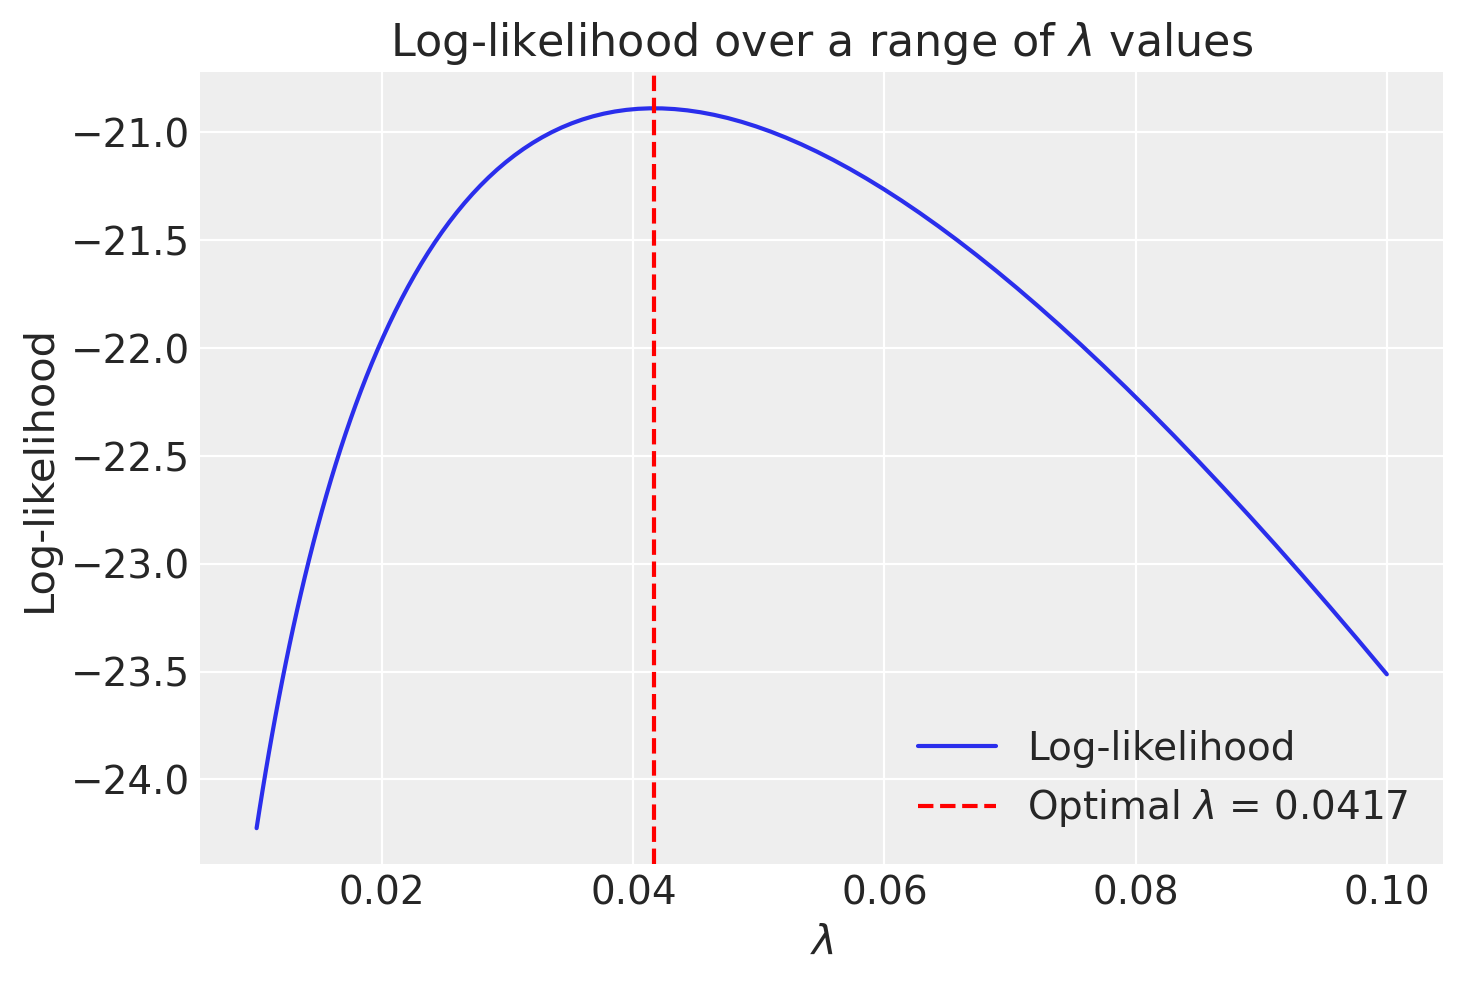

In [35]:
lambda_opt = result.x[0]
lambda_array = np.geomspace(0.01, 0.1, 100)
LL = [-neg_log_likelihood(L, data) for L in lambda_array]

plt.plot(lambda_array, LL, label='Log-likelihood')
plt.axvline(lambda_opt, color='r', linestyle='--', label=f'Optimal $\lambda$ = {lambda_opt:.4f}')
plt.xlabel('$\lambda$')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood over a range of $\lambda$ values')
plt.legend()
plt.show()

:::

## Conclusione e Riflessioni Finali

La funzione di verosimiglianza rappresenta un elemento cruciale che collega i dati osservati ai parametri di un modello statistico. Essa fornisce una misura della plausibilità dei dati in relazione a diversi valori possibili dei parametri del modello. La strutturazione di una funzione di verosimiglianza richiede la considerazione di tre componenti fondamentali: il modello statistico che si presume abbia generato i dati, l'insieme di valori possibili per i parametri di tale modello e le osservazioni empiriche che effettivamente abbiamo a disposizione.

La funzione di verosimiglianza è centrale nella pratica dell'inferenza statistica. Essa ci permette di quantificare quanto bene differenti set di parametri potrebbero aver generato i dati osservati. Questo è fondamentale sia per la selezione del modello che per la stima dei parametri, e pertanto è indispensabile per un'analisi dati rigorosa e per un'interpretazione accurata dei risultati.

Un'applicazione pratica e illustrativa dei principi esposti in questo capitolo è fornita nella sezione sul modello Rescorla-Wagner, che è un esempio di come la teoria della verosimiglianza possa essere applicata per affrontare questioni empiriche in psicologia.

In sintesi, la comprensione e l'applicazione appropriata della funzione di verosimiglianza sono passaggi essenziali nel processo di analisi dati. Essa costituisce uno strumento indispensabile per chi è impegnato nella ricerca empirica e nell'interpretazione di dati complessi.

## Esercizi

::: {#exr-entropy-1}

Spiega ciascuno dei concetti seguenti con una frase:

- probabilità.
- funzione di massa di probabilità.
- funzione di densità di probabilità.
- distribuzione di probabilità.
- distribuzione di probabilità discreta.
- distribuzione di probabilità continua.
- funzione di distribuzione cumulativa (cdf).
- verosimiglianza

:::

::: {.callout-warning}
All'esame ti verrà chiesto di:

- Calcolare la funzione di verosimiglianza binomiale e riportare il valore della funzione in corrispondenza di specifici valori $\theta$.
- Calcolare la funzione di verosimiglianza del modello gaussiano, per $\sigma$ noto, e riportare il valore della funzione in corrispondenza di specifici valori $\mu$.
- Calcolare la stima di massima verosimiglianza.
- Rispondere a domande che implicano una adeguata comprensione del concetto di funzione di verosimiglianza.
:::

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Oct 13 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
scipy     : 1.14.0
arviz     : 0.18.0
matplotlib: 3.9.1
pandas    : 2.2.2
numpy     : 1.26.4

Watermark: 2.4.3

